# MCCE-generated water distribution in Gramicidin channel
In the following, we take a look at data generated from MCCE.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
fontsize=10
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : fontsize}

plt.rc('font', **font)
import sys
import numpy as np
import mdtraj as md
import parmed as pm
from collections import OrderedDict
from __future__ import division
from sstmap.grid_water_analysis import *
from sstmap.utils import write_watpdb_from_coords


/Users/kamranhaider/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Obtain occupacy data

In [2]:
def read_head3lst(head3lst_file):
    residues = OrderedDict()
    with open(head3lst_file, 'r') as f:
        lines = [l.strip().split() for l in f.readlines()]
        header = lines.pop(0)
        data = [l[2:-1] for l in lines]
        conf_names = [l[1] for l in lines]
        for index, d in enumerate(data):
            if d[0] == "f":
                d[0] = 0
            else:
                d[0] = 1
            data[index] = [float(i) for i in d]
        for index, n in enumerate(conf_names):
            #print n, n[0:3] + n[5:10]
            k = n[0:3] + n[5:10]
            if k not in residues.keys():
                residues[k] = [index]
            else:
                residues[k].append(index)
        
    return header, conf_names, residues, np.asarray(data)

def read_fort38(fort38_file):
    with open(fort38_file, 'r') as f:
        lines = [l.strip().split() for l in f.readlines()]
        header = lines.pop(0)
        data = OrderedDict()
        for l in lines:
            line = [float(i) for i in l[1:]]
            data[l[0]] = line
        return data


Use occupancy data to write out a new pdb fie for high occupancy waters.

In [35]:
occ_data = read_fort38("../data/mcce_water_profiling/10_conf_per_water/fort_1.0.38")
res_occ = []
for k in occ_data.keys():
    if "DM" in k:
        res_occ.append(1 - occ_data[k][0])
s = md.load_pdb("../data/mcce_water_profiling/10_conf_per_water/step2_out.pdb")
wat_O_ids = s.topology.select("water and name O")
coords = []
i = 0
for index in range(0, wat_O_ids.shape[0], 10):
    O_index = wat_O_ids[index]
    occ = res_occ[i]
    if occ > 0.1:
        print index, wat_O_ids[index], s.topology.atom(wat_O_ids[index]), res_occ[i]
        O_coords = s.xyz[0, O_index, :]
        coords.append(O_coords*10.0)
    i += 1
print len(coords)
write_watpdb_from_coords("../data/mcce_water_profiling/10_conf_per_water/high_occ_waters", coords)

250 1282 HOH26-O 0.547
1390 4702 HOH140-O 0.769
2210 7162 HOH222-O 0.281
2650 8482 HOH266-O 0.712
3600 11332 HOH361-O 0.428
3750 11782 HOH376-O 0.686
6


## Generating density plots


In [6]:
def initialize_grid(center, resolution, dimensions):
    """
    Initialize a grid over the system
    """
    # set grid center, res and dimension
    # self.center = np.array(center,dtype=np.float_)
    # self.dims = np.array(dimensions)
    # self.spacing = np.array(resolution,dtype=np.float_)
    print("Initializing ...")
    center = np.array(center, dtype=np.float_)
    dims = np.array(dimensions, dtype=np.int_)
    spacing = np.array(resolution, dtype=np.float_)
    gridmax = dims * spacing + 1.5
    # set origin
    o = center - (0.5 * dims * spacing)
    origin = np.around(o, decimals=3)
    # set grid size (in terms of total points alog each axis)
    length = np.array(dims / spacing, dtype=np.float_)
    grid_size = np.ceil((length / spacing) + 1.0)
    grid_size = np.cast['uint32'](grid_size)
    # Finally allocate the space for the grid
    grid = np.zeros(dims, dtype=np.int_)

    v_count = 0
    voxel_array = np.zeros((grid.size, 6), dtype="float64")
    # print voxel_quarts_new.shape
    for index, value in np.ndenumerate(grid):
        # point = grid.pointForIndex(index) # get cartesian coords for the
        # grid point
        _index = np.array(index, dtype=np.int32)
        # point = self.spacing * _index + self._origin
        point = _index * spacing + origin + 0.5 * spacing
        voxel_array[v_count, 1] = point[0]
        voxel_array[v_count, 2] = point[1]
        voxel_array[v_count, 3] = point[2]
        voxel_array[v_count, 0] = v_count
        # print voxel_quarts_new[v_count, 0], voxel_quarts_new[v_count, 1],
        # voxel_quarts_new[v_count, 2]
        # create a dictionary key-value pair with voxel index as key and
        # it's coords as
        # voxel_quarts[v_count].append(np.zeros(14, dtype="float64"))
        v_count += 1
    return voxel_array, grid


In [7]:
input_file = "../data/mcce_water_profiling/1_conf_per_water/prot_step2_out.pdb"
lig = md.load_pdb(input_file, no_boxchk=True)
com = np.zeros((lig.n_frames, 3))
masses = np.ones(lig.n_atoms)
masses /= masses.sum()
com[0, :] = lig.xyz[0, :].astype('float64').T.dot(masses)
grid_center = com[0, :] * 10.0
grid_res = [0.5, 0.5, 0.5]
grid_dims = [16.0, 16.0, 44.0]
dims = np.array(grid_dims, dtype=np.int_)
grid_origin = grid_center - (0.5 * dims * grid_res)

In [16]:
dens_results = []
pt_regions = []
wat_nums = []
data = [(1, 1), (2, 5), (3, 10), (4, 25)]
# for each dataset
for d in data:
    print(d)
    # Initialize the grid
    g, grid = initialize_grid(grid_center, grid_res, grid_dims)
    d0 = d[0]
    d1 = d[1]
    
    occ_data = read_fort38("../data/mcce_water_profiling/"+ str(d1) + "_conf_per_water/fort_1.0.38")
    res_occ = []
    wat_sum = 0
    i = 0
    for k in occ_data.keys():
        if "DM" in k:
            res_occ.append(1 - occ_data[k][0])
            wat_sum += 1 - occ_data[k][0]
            i += 1
    wat_nums.append(wat_sum)
    s = md.load_pdb("../data/mcce_water_profiling/" + str(d1) + "_conf_per_water/step2_out.pdb")
    wat_O_ids = s.topology.select("water and name O")
    coords = []
    i = 0
    for index in range(0, wat_O_ids.shape[0], 25):
        O_index = wat_O_ids[index]
        occ = res_occ[i]
        O_coords = s.xyz[0, O_index, :]
        #print index, wat_O_ids[index], s.topology.atom(wat_O_ids[index]), res_occ[i], np.round(O_coords*10.0, 3)
    prot_coords = lig.xyz[0, :, :] * 10.0
    search_space = NeighborSearch(prot_coords, 2.4)
    search_space_2 = NeighborSearch(prot_coords, 1.6)
    n_wats = 0
    water_ids = range(0, wat_O_ids.shape[0], 25)
    i = 0
    dens = np.zeros(g.shape[0])
    pt = np.zeros(g.shape[0])
    for pt_i in xrange(g.shape[0]):
        pt_coords = g[pt_i, 1:4]
        nn = search_space.query_nbrs_single_point(pt_coords)
        nn_2 = search_space_2.query_nbrs_single_point(pt_coords)
        if len(nn) == 0:
            #print i, res_occ[i-1]
            #print pt_i, pt_coords, wat_O_ids[water_ids[i]], res_occ[i]
            dens[pt_i] += res_occ[i]
            i += 1
        #else:
        if len(nn_2) == 0:
            if pt_coords[0] == 23.479:
                pt[pt_i] = 1
    wat = dens.reshape(dims)
    prot = pt.reshape(dims)
    d = wat.shape
    slab_1 = np.zeros((d[1], d[2]))
    slab_2 = np.zeros((d[1], d[2]))
    for j in xrange(d[1]):
        for k in xrange(d[2]):
            slab_1[j, k] += np.sum(wat[:, j, k])
            slab_2[j, k] = np.sum(prot[:, j, k])
    dens_results.append(slab_1)
    pt_regions.append(slab_2)
    
    #print len(res_occ)
    print i, len(res_occ)
    print g.shape
    dx_header = ""
    dx_header += 'object 1 class gridpositions counts %d %d %d\n' % (
        grid_dims[0], grid_dims[1], grid_dims[2])
    dx_header += 'origin %.3f %.3f %.3f\n' % (
        grid_origin[0], grid_origin[1], grid_origin[2])
    dx_header += 'delta %.1f 0 0\n' % (grid_res[0])
    dx_header += 'delta 0 %.1f 0\n' % (grid_res[1])
    dx_header += 'delta 0 0 %.1f\n' % (grid_res[2])
    dx_header += 'object 2 class gridconnections counts %d %d %d\n' % (
        grid_dims[0], grid_dims[1], grid_dims[2])
    dx_header += 'object 3 class array type double rank 0 items %d data follows\n' % (
        grid_dims[0] * grid_dims[1] * grid_dims[2])

    with open("../data/mcce_water_profiling/"+ str(d1) +"_conf_per_water/mcce_occ.dx", "w") as f:
        f.write(dx_header)
        for k in range(1, len(dens) + 1):
            # print "writing data for voxel: ", k
            f.write("%g " % (dens[k - 1]))
            if k % 3 == 0:
                f.write("\n")

    print(dens.shape)
    


(1, 1)
Initializing ...
528 528
(11264, 6)
(11264,)
(2, 5)
Initializing ...
528 528
(11264, 6)
(11264,)
(3, 10)
Initializing ...
528 528
(11264, 6)
(11264,)
(4, 25)
Initializing ...
528 528
(11264, 6)
(11264,)


(0, 0)
7.045
(0, 1)
7.11
(1, 0)
7.084
(1, 1)
7.516


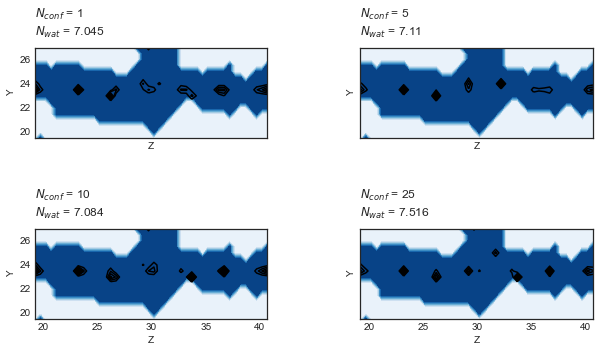

In [14]:
# can use grep -v DM fort.38 | grep HOH | awk '{s+=$2}END{print s}' to get it directly
#y = g[range(0, g.shape[0], grid.shape[2]), 2]
#z = g[0:grid.shape[2], 3]
conf_nums = [1, 5, 10, 25]
grid_start = g[0, 1:4]
grid_end = g[-1, 1:4]
x = np.arange(grid_start[2], grid_end[2] + 0.5, 0.5)
y = np.arange(grid_start[1], grid_end[1] + 0.5, 0.5)
X, Y = np.meshgrid(x, y)
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(10, 5))
fig.subplots_adjust(hspace=1.0, wspace=0.4)
sub_plot_indices = [(i, j) for i in range(2) for j in range(2)]
for index, data in enumerate(dens_results):
    i, j = sub_plot_indices[index]
    print(i, j)
    print(np.sum(data))
    ## Or kernel density estimate plot instead of the contourf plot
    #ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
    # Label plot
    ax[i, j].set_xlabel('Z')
    ax[i, j].set_ylabel('Y')
    #cfset = ax[i, j].contourf(x, y, data, cmap="Blues")
    cfset = ax[i, j].contour(x, y, data, colors="black")
    ax[i, j].clabel(cfset, inline=1, fontsize=10)
    cfset = ax[i, j].contourf(x, y, pt_regions[index], cmap='Blues')
    text = "$N_{conf}$ = " + str(conf_nums[index]) + "\n$N_{wat}$ = " + str(wat_nums[index])
    ax[i, j].text(x[0], y[-1]+1.0, text, fontsize=12)
#plt.colorbar(cfset)
    


In [15]:
xlist = np.linspace(-3.0, 3.0, 3)
ylist = np.linspace(-3.0, 3.0, 4)
X, Y = np.meshgrid(xlist, ylist)
Z = np.sqrt(X**2 + Y**2)
print(X.shape, Y.shape, Z.shape)

((4, 3), (4, 3), (4, 3))


In [292]:
x = g[range(0, g.shape[0], grid.shape[1]*grid.shape[2]), 1]
#print(x)
#print(x.shape)
xlist = np.linspace(-3.0, 3.0, 100)
ylist = np.linspace(-3.0, 3.0, 100)
X, Y = np.meshgrid(xlist, ylist)
Z = np.sqrt(X**2 + Y**2)